In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,...,[5.9604645e-08 9.2448264e-02 7.0119813e-02 ......,0,1304,2464,3832,4680,5664,6488,9840,1
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,...,[3.3713877e-07 6.0990625e-03 8.3317189e-03 ......,0,2112,5664,6304,6840,7704,9304,11776,1
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,...,[4.5448542e-07 2.2871116e-02 2.1308355e-02 ......,0,2032,3168,4648,5800,6728,7400,9512,1
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,928,1984,3232,4120,5120,5808,7352,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2104,3672,4808,5928,6944,7600,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 23, 23)

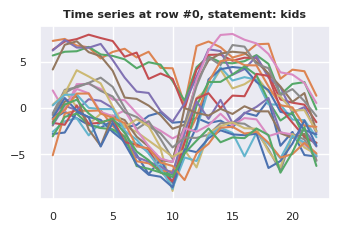

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


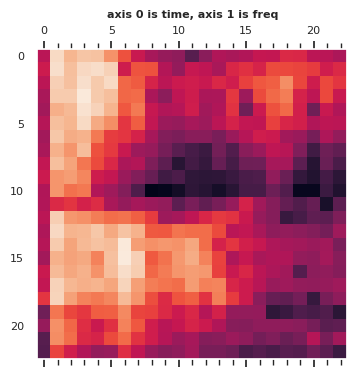

In [7]:
plt.matshow(traces[index]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

In [8]:
from sklearn.model_selection import train_test_split

# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 23, 23), (387, 23, 23), (520, 23, 23), (1545,), (387,), (520,))

# CNN for statement and syllables 0&2

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [10]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

2023-06-26 17:33:53.560874: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 17:33:53.644904: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 17:33:53.646246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 17:33:55.046247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Test to check the accuracy of a "belly" network
test_model = build_model((23,23), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 19, 8)             928       
                                                                 
 batch_normalization (BatchN  (None, 19, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 19, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 15, 8)             328       
                                                                 
 batch_normalization_1 (Batc  (None, 15, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 15, 8)             0

In [12]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 1)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 17:34:04,241] A new study created in memory with name: no-name-736d9599-46d0-4141-b7a4-3353f10ea9e3


Running little bitch having n_conv=1, dropout=0.9067288246196787, hidden_nodes=198
Running little bitch having n_conv=1, dropout=0.8484644186204721, hidden_nodes=180
Running little bitch having n_conv=2, dropout=0.4661733742787627, hidden_nodes=229
Running little bitch having n_conv=2, dropout=0.5267892280411214, hidden_nodes=175


[W 2023-06-26 17:34:04,550] Trial 1 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 180, 'dropout': 0.8484644186204721, 'filters': 15, 'kernel_size': 15, 'batch_size': 25, 'epochs': 32} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.6689096855590054, hidden_nodes=74


[W 2023-06-26 17:34:04,949] Trial 3 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 175, 'dropout': 0.5267892280411214, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.7825661246659592, hidden_nodes=34


[W 2023-06-26 17:34:05,303] Trial 5 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 34, 'dropout': 0.7825661246659592, 'filters': 8, 'kernel_size': 15, 'batch_size': 41, 'epochs': 15} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in bu

Running little bitch having n_conv=3, dropout=0.9709823185604265, hidden_nodes=245
Running little bitch having n_conv=1, dropout=0.6955830839340889, hidden_nodes=224


[W 2023-06-26 17:34:05,621] Trial 6 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 245, 'dropout': 0.9709823185604265, 'filters': 10, 'kernel_size': 14, 'batch_size': 37, 'epochs': 74} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=0, dropout=0.11221847257812934, hidden_nodes=90
Running little bitch having n_conv=2, dropout=0.7332502917342925, hidden_nodes=199
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 17:34:22,889] Trial 0 finished with value: 0.9457364341085271 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 198, 'dropout': 0.9067288246196787, 'filters': 5, 'kernel_size': 8, 'batch_size': 60, 'epochs': 22}. Best is trial 0 with value: 0.9457364341085271.


Running little bitch having n_conv=2, dropout=0.9787214197782138, hidden_nodes=122


[W 2023-06-26 17:34:23,164] Trial 10 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 122, 'dropout': 0.9787214197782138, 'filters': 13, 'kernel_size': 15, 'batch_size': 54, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.47331750878277157, hidden_nodes=131


[W 2023-06-26 17:34:23,623] Trial 11 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 131, 'dropout': 0.47331750878277157, 'filters': 8, 'kernel_size': 12, 'batch_size': 58, 'epochs': 50} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=2, dropout=0.18792287726472923, hidden_nodes=89


[W 2023-06-26 17:34:23,907] Trial 12 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.18792287726472923, 'filters': 9, 'kernel_size': 15, 'batch_size': 34, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=2, dropout=0.6442948475596868, hidden_nodes=110


[W 2023-06-26 17:34:24,187] Trial 13 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 110, 'dropout': 0.6442948475596868, 'filters': 6, 'kernel_size': 16, 'batch_size': 23, 'epochs': 74} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=1, dropout=0.24615992457863434, hidden_nodes=84
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 17:34:32,712] Trial 9 finished with value: 0.9509043927648578 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 199, 'dropout': 0.7332502917342925, 'filters': 14, 'kernel_size': 4, 'batch_size': 34, 'epochs': 14}. Best is trial 9 with value: 0.9509043927648578.


Running little bitch having n_conv=1, dropout=0.5706693489981097, hidden_nodes=195
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 17:34:39,053] Trial 8 finished with value: 0.979328165374677 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 90, 'dropout': 0.11221847257812934, 'filters': 9, 'kernel_size': 13, 'batch_size': 63, 'epochs': 79}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=3, dropout=0.7904650708980957, hidden_nodes=13


[W 2023-06-26 17:34:39,609] Trial 16 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.7904650708980957, 'filters': 14, 'kernel_size': 7, 'batch_size': 24, 'epochs': 34} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.7797362366804346, hidden_nodes=40


[W 2023-06-26 17:34:39,986] Trial 17 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 40, 'dropout': 0.7797362366804346, 'filters': 8, 'kernel_size': 12, 'batch_size': 41, 'epochs': 43} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in b

Running little bitch having n_conv=0, dropout=0.7551505122785813, hidden_nodes=83
13/13 [==============================] - 1s 13ms/step


[I 2023-06-26 17:34:42,810] Trial 2 finished with value: 0.9638242894056848 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 229, 'dropout': 0.4661733742787627, 'filters': 14, 'kernel_size': 4, 'batch_size': 40, 'epochs': 23}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=3, dropout=0.09912034138330994, hidden_nodes=123
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 17:34:55,258] Trial 14 finished with value: 0.9664082687338501 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 84, 'dropout': 0.24615992457863434, 'filters': 11, 'kernel_size': 12, 'batch_size': 38, 'epochs': 33}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=2, dropout=0.5544246795576697, hidden_nodes=96
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 17:34:57,207] Trial 18 finished with value: 0.8630490956072352 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 83, 'dropout': 0.7551505122785813, 'filters': 13, 'kernel_size': 2, 'batch_size': 37, 'epochs': 19}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.9239450548135527, hidden_nodes=165
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 17:35:12,254] Trial 21 finished with value: 0.9457364341085271 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 165, 'dropout': 0.9239450548135527, 'filters': 9, 'kernel_size': 4, 'batch_size': 26, 'epochs': 12}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=2, dropout=0.669957742404931, hidden_nodes=146


[W 2023-06-26 17:35:12,536] Trial 22 failed with parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 146, 'dropout': 0.669957742404931, 'filters': 13, 'kernel_size': 15, 'batch_size': 44, 'epochs': 17} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.7639955832333076, hidden_nodes=176


[W 2023-06-26 17:35:13,028] Trial 23 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 176, 'dropout': 0.7639955832333076, 'filters': 10, 'kernel_size': 10, 'batch_size': 51, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.8182491376217416, hidden_nodes=19
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 17:35:14,515] Trial 15 finished with value: 0.937984496124031 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 195, 'dropout': 0.5706693489981097, 'filters': 3, 'kernel_size': 6, 'batch_size': 39, 'epochs': 59}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=2, dropout=0.11758425550318652, hidden_nodes=22
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 17:35:39,148] Trial 24 finished with value: 0.9638242894056848 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 19, 'dropout': 0.8182491376217416, 'filters': 6, 'kernel_size': 9, 'batch_size': 51, 'epochs': 34}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.41740692526218137, hidden_nodes=31
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 17:35:42,441] Trial 19 finished with value: 0.937984496124031 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 123, 'dropout': 0.09912034138330994, 'filters': 2, 'kernel_size': 5, 'batch_size': 50, 'epochs': 76}. Best is trial 8 with value: 0.979328165374677.


Running little bitch having n_conv=0, dropout=0.013196311121722148, hidden_nodes=18
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 17:35:54,308] Trial 20 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 96, 'dropout': 0.5544246795576697, 'filters': 9, 'kernel_size': 7, 'batch_size': 18, 'epochs': 48}. Best is trial 20 with value: 0.9870801033591732.


Running little bitch having n_conv=3, dropout=0.06083857869725019, hidden_nodes=65


[W 2023-06-26 17:35:54,738] Trial 28 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 65, 'dropout': 0.06083857869725019, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.005333471813011137, hidden_nodes=61


[W 2023-06-26 17:35:55,126] Trial 29 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 61, 'dropout': 0.005333471813011137, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.02768639495340816, hidden_nodes=52


[W 2023-06-26 17:35:55,510] Trial 30 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.02768639495340816, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.0048495694715049165, hidden_nodes=58


[W 2023-06-26 17:35:55,945] Trial 31 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.0048495694715049165, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 81} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.0027039700373930192, hidden_nodes=64


[W 2023-06-26 17:35:56,341] Trial 32 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 64, 'dropout': 0.0027039700373930192, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.06136565371033953, hidden_nodes=57


[W 2023-06-26 17:35:56,684] Trial 33 failed with value None.


Running little bitch having n_conv=3, dropout=0.007119426583798369, hidden_nodes=54


[W 2023-06-26 17:35:57,067] Trial 34 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.007119426583798369, 'filters': 9, 'kernel_size': 15, 'batch_size': 17, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.007227718043312015, hidden_nodes=59
Running little bitch having n_conv=3, dropout=0.004629721463968228, hidden_nodes=50


[W 2023-06-26 17:35:57,880] Trial 36 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.004629721463968228, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.0034145865575405665, hidden_nodes=72


[W 2023-06-26 17:35:58,326] Trial 37 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 72, 'dropout': 0.0034145865575405665, 'filters': 9, 'kernel_size': 14, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, 

Running little bitch having n_conv=3, dropout=0.005032495025262124, hidden_nodes=58


[W 2023-06-26 17:35:58,731] Trial 38 failed with value None.


Running little bitch having n_conv=3, dropout=0.015210018740668185, hidden_nodes=55


[W 2023-06-26 17:35:59,142] Trial 39 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 55, 'dropout': 0.015210018740668185, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.005265367122657683, hidden_nodes=54
Running little bitch having n_conv=3, dropout=0.0002900345985121927, hidden_nodes=65


[W 2023-06-26 17:35:59,858] Trial 41 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 65, 'dropout': 0.0002900345985121927, 'filters': 9, 'kernel_size': 15, 'batch_size': 17, 'epochs': 80} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.05125501871303738, hidden_nodes=58


[W 2023-06-26 17:36:00,485] Trial 42 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.05125501871303738, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 82} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.31947838785687005, hidden_nodes=65


[W 2023-06-26 17:36:01,197] Trial 44 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 59, 'dropout': 0.042039550400304326, 'filters': 8, 'kernel_size': 15, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.042039550400304326, hidden_nodes=59
Running little bitch having n_conv=3, dropout=0.3441654673795194, hidden_nodes=57


[W 2023-06-26 17:36:01,551] Trial 45 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 57, 'dropout': 0.3441654673795194, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in b

Running little bitch having n_conv=3, dropout=0.34538599117807606, hidden_nodes=54


[W 2023-06-26 17:36:02,041] Trial 46 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.34538599117807606, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 81} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.3302846370021689, hidden_nodes=58
Running little bitch having n_conv=3, dropout=0.06393225221280041, hidden_nodes=54


[W 2023-06-26 17:36:02,740] Trial 48 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.06393225221280041, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.005042696010494341, hidden_nodes=54


[W 2023-06-26 17:36:03,128] Trial 49 failed with value None.
[W 2023-06-26 17:36:03,427] Trial 50 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 59, 'dropout': 0.0474283268562643, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)

Running little bitch having n_conv=3, dropout=0.0474283268562643, hidden_nodes=59
Running little bitch having n_conv=3, dropout=0.014122379778602312, hidden_nodes=59


[W 2023-06-26 17:36:03,792] Trial 51 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 59, 'dropout': 0.014122379778602312, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 81} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=2, dropout=0.025258358634124956, hidden_nodes=52


[W 2023-06-26 17:36:04,276] Trial 52 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.025258358634124956, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.039480673816945186, hidden_nodes=82


[W 2023-06-26 17:36:04,778] Trial 53 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 82, 'dropout': 0.039480673816945186, 'filters': 9, 'kernel_size': 16, 'batch_size': 21, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.008174165941871633, hidden_nodes=54


[W 2023-06-26 17:36:05,175] Trial 54 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.008174165941871633, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.028208023831191836, hidden_nodes=55
Running little bitch having n_conv=3, dropout=0.3346384735770228, hidden_nodes=55


[W 2023-06-26 17:36:05,876] Trial 56 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 55, 'dropout': 0.3346384735770228, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in b

Running little bitch having n_conv=3, dropout=0.32229190037773114, hidden_nodes=55


[W 2023-06-26 17:36:06,342] Trial 57 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 55, 'dropout': 0.32229190037773114, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.04644158892661954, hidden_nodes=54


[W 2023-06-26 17:36:06,714] Trial 58 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.04644158892661954, 'filters': 9, 'kernel_size': 15, 'batch_size': 17, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.0008298087530999032, hidden_nodes=58


[W 2023-06-26 17:36:07,394] Trial 60 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 69, 'dropout': 0.017290216067021483, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.017290216067021483, hidden_nodes=69
Running little bitch having n_conv=3, dropout=0.324915809316883, hidden_nodes=57


[W 2023-06-26 17:36:07,785] Trial 61 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 57, 'dropout': 0.324915809316883, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in bu

Running little bitch having n_conv=3, dropout=0.3445708859048155, hidden_nodes=52


[W 2023-06-26 17:36:08,471] Trial 63 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 56, 'dropout': 0.33499701583141617, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.33499701583141617, hidden_nodes=56
Running little bitch having n_conv=3, dropout=0.006666133484675915, hidden_nodes=58


[W 2023-06-26 17:36:08,848] Trial 64 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.006666133484675915, 'filters': 9, 'kernel_size': 16, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.023150715300245484, hidden_nodes=52


[W 2023-06-26 17:36:09,190] Trial 65 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.023150715300245484, 'filters': 9, 'kernel_size': 16, 'batch_size': 18, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.010699891304615461, hidden_nodes=58


[W 2023-06-26 17:36:09,572] Trial 66 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.010699891304615461, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.010808331247742081, hidden_nodes=58


[W 2023-06-26 17:36:09,986] Trial 67 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.010808331247742081, 'filters': 9, 'kernel_size': 16, 'batch_size': 17, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3403022804892796, hidden_nodes=59


[W 2023-06-26 17:36:10,329] Trial 68 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 59, 'dropout': 0.3403022804892796, 'filters': 9, 'kernel_size': 15, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in b

Running little bitch having n_conv=3, dropout=0.05144597686156295, hidden_nodes=61
13/13 [==============================] - 1s 15ms/step


[W 2023-06-26 17:36:11,094] Trial 70 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 58, 'dropout': 0.010262387492923922, 'filters': 9, 'kernel_size': 16, 'batch_size': 20, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.29535470672351966, hidden_nodes=30
Running little bitch having n_conv=3, dropout=0.3470600194408203, hidden_nodes=10


[W 2023-06-26 17:36:11,535] Trial 71 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.3470600194408203, 'filters': 11, 'kernel_size': 16, 'batch_size': 26, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3395058562743759, hidden_nodes=8
Running little bitch having n_conv=3, dropout=0.34712159576361323, hidden_nodes=25


[W 2023-06-26 17:36:12,038] Trial 73 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.3395058562743759, 'filters': 10, 'kernel_size': 16, 'batch_size': 16, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.360204458661317, hidden_nodes=17


[W 2023-06-26 17:36:12,424] Trial 75 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 17, 'dropout': 0.360204458661317, 'filters': 11, 'kernel_size': 16, 'batch_size': 21, 'epochs': 60} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.3621934938700035, hidden_nodes=13


[W 2023-06-26 17:36:12,899] Trial 76 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.3621934938700035, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.34727205299647623, hidden_nodes=10
Running little bitch having n_conv=3, dropout=0.34426326294637044, hidden_nodes=11


[W 2023-06-26 17:36:13,194] Trial 77 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.34727205299647623, 'filters': 16, 'kernel_size': 16, 'batch_size': 20, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3831089226270011, hidden_nodes=9


[W 2023-06-26 17:36:13,569] Trial 79 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.3831089226270011, 'filters': 16, 'kernel_size': 16, 'batch_size': 23, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.4051833658020018, hidden_nodes=14


[W 2023-06-26 17:36:13,975] Trial 78 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 11, 'dropout': 0.34426326294637044, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3450482888548675, hidden_nodes=11


[W 2023-06-26 17:36:14,384] Trial 81 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 11, 'dropout': 0.3450482888548675, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3453075894943647, hidden_nodes=15
Running little bitch having n_conv=3, dropout=0.35269963238376734, hidden_nodes=12


[W 2023-06-26 17:36:15,280] Trial 82 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 15, 'dropout': 0.3453075894943647, 'filters': 11, 'kernel_size': 7, 'batch_size': 16, 'epochs': 57} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.34131773787187114, hidden_nodes=8
Running little bitch having n_conv=3, dropout=0.3594784358309058, hidden_nodes=10


[W 2023-06-26 17:36:16,249] Trial 84 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.34131773787187114, 'filters': 16, 'kernel_size': 7, 'batch_size': 18, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.3641598890539428, hidden_nodes=9


[W 2023-06-26 17:36:16,767] Trial 86 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.3641598890539428, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.37908965400914396, hidden_nodes=10
Running little bitch having n_conv=3, dropout=0.3231645740741036, hidden_nodes=25


[W 2023-06-26 17:36:17,189] Trial 88 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 25, 'dropout': 0.3231645740741036, 'filters': 16, 'kernel_size': 16, 'batch_size': 19, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.37195381927762006, hidden_nodes=24


[W 2023-06-26 17:36:17,576] Trial 89 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 24, 'dropout': 0.37195381927762006, 'filters': 16, 'kernel_size': 16, 'batch_size': 18, 'epochs': 56} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.34527568878191434, hidden_nodes=16Running little bitch having n_conv=3, dropout=0.35668072820772073, hidden_nodes=30



[W 2023-06-26 17:36:18,029] Trial 91 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 16, 'dropout': 0.34527568878191434, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 60} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3524099617823093, hidden_nodes=13
Running little bitch having n_conv=3, dropout=0.3706027549603297, hidden_nodes=12


[W 2023-06-26 17:36:18,907] Trial 92 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.3524099617823093, 'filters': 11, 'kernel_size': 7, 'batch_size': 16, 'epochs': 57} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.3546424202576684, hidden_nodes=37
Running little bitch having n_conv=3, dropout=0.32690735000931326, hidden_nodes=12


[W 2023-06-26 17:36:19,427] Trial 95 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.32690735000931326, 'filters': 16, 'kernel_size': 16, 'batch_size': 19, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.34503157966885134, hidden_nodes=15
Running little bitch having n_conv=3, dropout=0.3436011941150714, hidden_nodes=12


[W 2023-06-26 17:36:20,340] Trial 96 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 15, 'dropout': 0.34503157966885134, 'filters': 16, 'kernel_size': 7, 'batch_size': 16, 'epochs': 57} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3617964011837456, hidden_nodes=51
Running little bitch having n_conv=3, dropout=0.34803965832371647, hidden_nodes=11


[W 2023-06-26 17:36:20,797] Trial 98 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 51, 'dropout': 0.3617964011837456, 'filters': 16, 'kernel_size': 16, 'batch_size': 20, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.36658530404487794, hidden_nodes=8
Running little bitch having n_conv=3, dropout=0.3225107498329641, hidden_nodes=8


[W 2023-06-26 17:36:21,319] Trial 100 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.36658530404487794, 'filters': 11, 'kernel_size': 16, 'batch_size': 22, 'epochs': 60} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3531094883962695, hidden_nodes=18
Running little bitch having n_conv=3, dropout=0.34834958021529466, hidden_nodes=15


[W 2023-06-26 17:36:21,845] Trial 102 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 18, 'dropout': 0.3531094883962695, 'filters': 11, 'kernel_size': 16, 'batch_size': 16, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.35487724023512385, hidden_nodes=9


[W 2023-06-26 17:36:22,341] Trial 103 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 15, 'dropout': 0.34834958021529466, 'filters': 16, 'kernel_size': 7, 'batch_size': 16, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3520629881662818, hidden_nodes=16


[W 2023-06-26 17:36:22,748] Trial 104 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.35487724023512385, 'filters': 16, 'kernel_size': 7, 'batch_size': 22, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.35151483588483456, hidden_nodes=12
Running little bitch having n_conv=3, dropout=0.3448226066988488, hidden_nodes=10


[W 2023-06-26 17:36:23,209] Trial 107 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.3448226066988488, 'filters': 16, 'kernel_size': 16, 'batch_size': 19, 'epochs': 57} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.31871375687059084, hidden_nodes=40


[W 2023-06-26 17:36:23,852] Trial 106 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 12, 'dropout': 0.35151483588483456, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 55} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.34182819567559136, hidden_nodes=13


[W 2023-06-26 17:36:24,375] Trial 108 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 40, 'dropout': 0.31871375687059084, 'filters': 11, 'kernel_size': 7, 'batch_size': 16, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3616165730005952, hidden_nodes=21


[W 2023-06-26 17:36:24,902] Trial 110 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 21, 'dropout': 0.3616165730005952, 'filters': 16, 'kernel_size': 16, 'batch_size': 22, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.35539559571018214, hidden_nodes=8
Running little bitch having n_conv=3, dropout=0.3595333991524102, hidden_nodes=19


[W 2023-06-26 17:36:25,580] Trial 111 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 8, 'dropout': 0.35539559571018214, 'filters': 11, 'kernel_size': 16, 'batch_size': 16, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.34502475067399563, hidden_nodes=29
Running little bitch having n_conv=3, dropout=0.37438013330534586, hidden_nodes=9


[W 2023-06-26 17:36:26,770] Trial 113 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 29, 'dropout': 0.34502475067399563, 'filters': 10, 'kernel_size': 7, 'batch_size': 16, 'epochs': 60} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, i

Running little bitch having n_conv=3, dropout=0.3543697168804965, hidden_nodes=8
Running little bitch having n_conv=3, dropout=0.35834318770530843, hidden_nodes=11


[W 2023-06-26 17:36:27,708] Trial 116 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 11, 'dropout': 0.35834318770530843, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 60} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, 

Running little bitch having n_conv=3, dropout=0.34227383515299903, hidden_nodes=11
Running little bitch having n_conv=3, dropout=0.33165721147544236, hidden_nodes=33


[W 2023-06-26 17:36:28,527] Trial 118 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 33, 'dropout': 0.33165721147544236, 'filters': 16, 'kernel_size': 16, 'batch_size': 16, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, 

Running little bitch having n_conv=3, dropout=0.3784058266606007, hidden_nodes=13
Running little bitch having n_conv=3, dropout=0.30447412476543867, hidden_nodes=10


[W 2023-06-26 17:36:29,438] Trial 119 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.3784058266606007, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 57} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3257576026862681, hidden_nodes=9


[W 2023-06-26 17:36:29,853] Trial 121 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.3257576026862681, 'filters': 16, 'kernel_size': 16, 'batch_size': 20, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3666450730793032, hidden_nodes=8Running little bitch having n_conv=3, dropout=0.3262003402732291, hidden_nodes=13



[W 2023-06-26 17:36:30,748] Trial 122 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 13, 'dropout': 0.3262003402732291, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3588020036472808, hidden_nodes=28
Running little bitch having n_conv=3, dropout=0.4238361988369882, hidden_nodes=10
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 17:36:31,509] Trial 27 finished with value: 0.9870801033591732 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 18, 'dropout': 0.013196311121722148, 'filters': 8, 'kernel_size': 16, 'batch_size': 63, 'epochs': 90}. Best is trial 20 with value: 0.9870801033591732.
[W 2023-06-26 17:36:31,754] Trial 124 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 28, 'dropout': 0.3588020036472808, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ip

Running little bitch having n_conv=3, dropout=0.36776787700542235, hidden_nodes=44


[W 2023-06-26 17:36:31,956] Trial 125 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 10, 'dropout': 0.4238361988369882, 'filters': 16, 'kernel_size': 7, 'batch_size': 17, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.336577941747802, hidden_nodes=49
Running little bitch having n_conv=3, dropout=0.35481769921370215, hidden_nodes=50


[W 2023-06-26 17:36:32,207] Trial 126 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 44, 'dropout': 0.36776787700542235, 'filters': 7, 'kernel_size': 16, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3651359774664531, hidden_nodes=47
Running little bitch having n_conv=3, dropout=0.34409421080021474, hidden_nodes=40


[W 2023-06-26 17:36:32,639] Trial 128 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.35481769921370215, 'filters': 7, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3534766580061017, hidden_nodes=49
Running little bitch having n_conv=3, dropout=0.36934854132920014, hidden_nodes=47


[W 2023-06-26 17:36:33,050] Trial 130 failed with value None.
[W 2023-06-26 17:36:33,299] Trial 131 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.3534766580061017, 'filters': 7, 'kernel_size': 16, 'batch_size': 17, 'epochs': 56} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(

Running little bitch having n_conv=3, dropout=0.3735022594128777, hidden_nodes=50


[W 2023-06-26 17:36:33,472] Trial 132 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.36934854132920014, 'filters': 7, 'kernel_size': 16, 'batch_size': 16, 'epochs': 58} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.31717732047806646, hidden_nodes=42
Running little bitch having n_conv=3, dropout=0.33669018908272064, hidden_nodes=54


[W 2023-06-26 17:36:33,710] Trial 133 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.3735022594128777, 'filters': 7, 'kernel_size': 16, 'batch_size': 17, 'epochs': 56} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.331694674225437, hidden_nodes=50
Running little bitch having n_conv=3, dropout=0.3550387399971279, hidden_nodes=53


[W 2023-06-26 17:36:34,083] Trial 135 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 54, 'dropout': 0.33669018908272064, 'filters': 6, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3557534818772127, hidden_nodes=47


[W 2023-06-26 17:36:34,592] Trial 138 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.3557534818772127, 'filters': 7, 'kernel_size': 16, 'batch_size': 16, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.4192440246737047, hidden_nodes=50
Running little bitch having n_conv=3, dropout=0.36393522003267276, hidden_nodes=47


[W 2023-06-26 17:36:34,826] Trial 136 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 50, 'dropout': 0.331694674225437, 'filters': 7, 'kernel_size': 11, 'batch_size': 18, 'epochs': 56} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in b

Running little bitch having n_conv=3, dropout=0.35651870317256584, hidden_nodes=59
Running little bitch having n_conv=3, dropout=0.3634891107120016, hidden_nodes=43


[W 2023-06-26 17:36:35,223] Trial 140 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.36393522003267276, 'filters': 7, 'kernel_size': 16, 'batch_size': 18, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

Running little bitch having n_conv=3, dropout=0.3536161777119782, hidden_nodes=49
Running little bitch having n_conv=3, dropout=0.3517224334444647, hidden_nodes=41


[W 2023-06-26 17:36:35,638] Trial 142 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 43, 'dropout': 0.3634891107120016, 'filters': 6, 'kernel_size': 16, 'batch_size': 18, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

 1/13 [=>............................] - ETA: 14s

[W 2023-06-26 17:36:35,835] Trial 143 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.3536161777119782, 'filters': 6, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.3197487190880219, hidden_nodes=49
13/13 [==============================] - 2s 32ms/step


[W 2023-06-26 17:36:36,174] Trial 145 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.3197487190880219, 'filters': 7, 'kernel_size': 16, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.35701055284338806, hidden_nodes=49


[W 2023-06-26 17:36:36,301] Trial 144 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.3517224334444647, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 56} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.4346171659145525, hidden_nodes=55
Running little bitch having n_conv=3, dropout=0.34738476027637355, hidden_nodes=52


[W 2023-06-26 17:36:36,835] Trial 148 failed with parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.34738476027637355, 'filters': 7, 'kernel_size': 15, 'batch_size': 18, 'epochs': 59} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_38777/4091589858.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_38777/4091589858.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_38777/1167308510.py", line 27, in

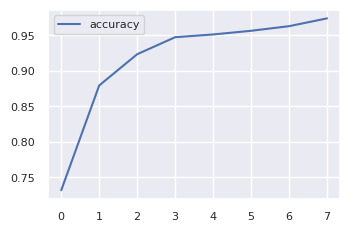

In [14]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [15]:
best_params = study.best_params
# best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)

In [17]:
cnn = build_model(**best_params)
cnn.summary()

TypeError: build_model() got an unexpected keyword argument 'batch_size'

In [19]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 4ms/step
Cohen k 0.9519230769230769
Accuracy 0.9759615384615384
F1-score [0.97560976 0.97630332]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       312
           1       0.96      0.99      0.98       312

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624



## CNN and emotion using complete STFT

In [38]:
X = np.load(os.path.join(TS_PREPROC_FOLDER, "full_stft.npy"))

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = X[:split_index]
X_test = X[split_index:]

y_train = df["emotion"][:split_index].to_numpy()
y_test = df["emotion"][split_index:].to_numpy()

X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_val.shape, X_test.shape, y_train_v.shape, y_val.shape, y_test.shape

((1462, 54, 54), (366, 54, 54), (624, 54, 54), (1462,), (366,), (624,))

In [39]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_v = label_encoder.transform(y_train_v)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_val[:10]

array([2, 0, 6, 4, 4, 0, 3, 6, 2, 6])

In [40]:
# Test to check the accuracy of a "belly" network
test_model = build_and_fit_cnn(X=X_train, y=y_train, n_conv=2, n_hidden=3, hidden_nodes=256, epochs=8, verbose=True)

Epoch 1/8
115/115 [==============================] - 5s 12ms/step - loss: 2.0459 - accuracy: 0.1674
Epoch 2/8
115/115 [==============================] - 1s 10ms/step - loss: 2.0373 - accuracy: 0.1570
Epoch 3/8
115/115 [==============================] - 1s 11ms/step - loss: 2.0310 - accuracy: 0.1712
Epoch 4/8
115/115 [==============================] - 1s 10ms/step - loss: 2.0270 - accuracy: 0.1690
Epoch 5/8
115/115 [==============================] - 1s 10ms/step - loss: 2.0141 - accuracy: 0.1772
Epoch 6/8
115/115 [==============================] - 1s 11ms/step - loss: 2.0127 - accuracy: 0.1729
Epoch 7/8
115/115 [==============================] - 1s 11ms/step - loss: 2.0085 - accuracy: 0.1926
Epoch 8/8
115/115 [==============================] - 1s 11ms/step - loss: 1.9945 - accuracy: 0.1947


In [48]:
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, X_train, y_train )
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 17:21:59,181] A new study created in memory with name: no-name-6e421921-3fd5-48e4-bf0b-dd4b1379f0a0
[W 2023-06-26 17:21:59,205] Trial 0 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 190, 'dropout': 0.13536993545843246, 'filters': 11, 'kernel_size': 14, 'batch_size': 57, 'epochs': 17} because of the following error: TypeError("build_model() missing 1 required positional argument: 'n_categories'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_35043/2900296876.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial, X_train, y_train )
  File "/tmp/ipykernel_35043/2718163810.py", line 15, in objective_fun
    cnn = build_model(  X.shape,
TypeError: build_model() missing 1 required positional argument: 'n_categories'
[W 2023-06-26 17:21:59,209] T

Running little bitch having n_conv=2, dropout=0.13536993545843246, hidden_nodes=190
Running little bitch having n_conv=0, dropout=0.8349298195911011, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.11512356360583886, hidden_nodes=146
Running little bitch having n_conv=2, dropout=0.5653741796537336, hidden_nodes=17


TypeError: build_model() missing 1 required positional argument: 'n_categories'

In [32]:
best_params = study.best_params
best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)
cnn = build_and_fit_cnn(**best_params)
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 10, 8)             2584      
                                                                 
 batch_normalization_11 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 10, 8)             0         
                                                                 
 global_average_pooling1d_5   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 248)               2232      
                                                                 
 dense_17 (Dense)            (None, 2)                

In [33]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

ValueError: in user code:

    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 23, 23), found shape=(None, 54, 54)
